# Concepts behind  Expectation-Maximisation algorithm 

Expectation-maximisation algorithm is notoriously difficult to grasp. 
In the following, we try to give down to earth practical explanations for all theoretical concepts inside EM algorithm.
To make it tractable, we consider all the necessary steps on a tiny toy example.  

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal

# Local imports
from common import *
from convenience import *

## I. Setup for the toy example

In the following, we consider a setting where the data is generated by two coloured Gaussian distributions with the same mean: $\mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma}_1)$ and $\mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma}_2)$ where cluster shapes are elongated ellipsoids with perpendicular directions of maximal variance. The mixture proportions are equal for simplicity.

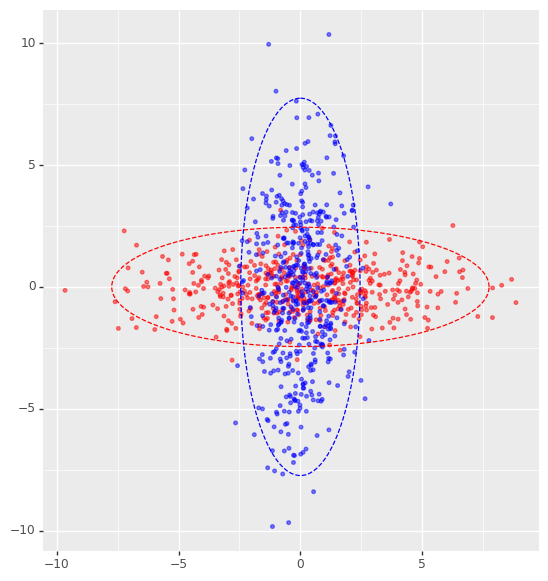

<ggplot: (-9223372036540953621)>

In [2]:
Mu = [None] * 2
Mu[0] = [0, 0]
Mu[1] = [0, 0]

Sigma = [None] * 2
Sigma[0] = np.array([[10, 0], [0,  1]])
Sigma[1] = np.array([[ 1, 0], [0, 10]])  

k = 500
df = [None] * 2
df[0] = DataFrame(multivariate_normal.rvs(size=k, mean=Mu[0], cov=Sigma[0]), 
                  columns=['x', 'y']).assign(z = 0)
df[1] = DataFrame(multivariate_normal.rvs(size=k, mean=Mu[1], cov=Sigma[1]), 
                  columns=['x', 'y']).assign(z = 1)
df = pd.concat(df).assign(z = lambda df: df['z'].astype('category'))


p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'z'), alpha = 0.5, size = 1)
p = p + geom_ellipse(mean = Mu[0], cov = Sigma[0], color='red',  linetype='--')
p = p + geom_ellipse(mean = Mu[1], cov = Sigma[1], color='blue', linetype='--')
p = p + scale_color_manual(values=['red','blue'], breaks=[0,1], guide = False)
p = p + scale_x_continuous(name="") + scale_y_continuous(name="") + coord_fixed()
display(p)

### Toy dataset 

As the number of potential cluster labellings $\boldsymbol{z}$ is exponential in the number of data points, we set the number of data points $n=8$.

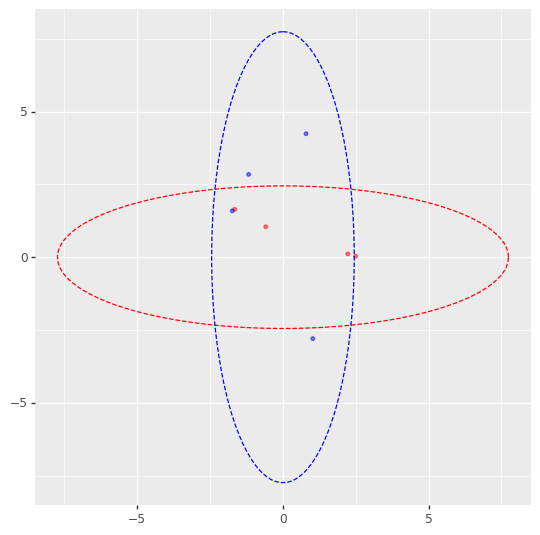

<ggplot: (-9223372036538828235)>

Data 
 
 
 x 
 y 
 z 
 
 
 
 
 -1.654607 
 1.643722 
 0 
 
 
 2.226186 
 0.111529 
 0 
 
 
 2.494062 
 0.034862 
 0 
 
 
 -0.590145 
 1.043962 
 0 
 
 
 -1.175698 
 2.841480 
 1 
 
 
 1.025951 
 -2.794289 
 1 
 
 
 -1.738357 
 1.591084 
 1 
 
 
 0.793505 
 4.238551 
 1

In [3]:
k = 4
n = 2 * k

df = [None] * 2
df[0] = DataFrame(multivariate_normal.rvs(size=k, mean=Mu[0], cov=Sigma[0]), 
                  columns=['x', 'y']).assign(z = 0)
df[1] = DataFrame(multivariate_normal.rvs(size=k, mean=Mu[1], cov=Sigma[1]), 
                  columns=['x', 'y']).assign(z = 1)
df = pd.concat(df).assign(z = lambda df: df['z'].astype('category'))


p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'z'), alpha = 0.5, size = 1)
p = p + geom_ellipse(mean = Mu[0], cov = Sigma[0], color='red',  linetype='--')
p = p + geom_ellipse(mean = Mu[1], cov = Sigma[1], color='blue', linetype='--')
p = p + scale_color_manual(values=['red','blue'], breaks=[0,1], guide = False)
p = p + scale_x_continuous(name="") + scale_y_continuous(name="") + coord_fixed()
display(p)

mdisplay([df],['Data'])

## II. Posterior distribution for cluster parameters

The central concept behind EM-algorithm is the marginal posterior 

\begin{align*}
P(\boldsymbol{\Theta})&=p[\boldsymbol{\Theta}|\boldsymbol{x}_1,\ldots,\boldsymbol{x}_1]
=\sum_{\boldsymbol{z}}p[\boldsymbol{\Theta},\boldsymbol{z}|\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n] \\
&=\sum_{\boldsymbol{z}}\frac{p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{z}|\boldsymbol{\Theta}]\cdot p[\boldsymbol{\Theta}]}{p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n]} 
\end{align*}
where $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n$ are observations, $\boldsymbol{z}=(z_1,\ldots,z_n)$ is the vector of unknown cluster labels and $\boldsymbol{\Theta}$ is the complete set of model parameters.
In most cases, we assign a non-informative prior to the model parameters and thus the marginal posterior is proportional to marginal likelihood:

\begin{align*}
L(\boldsymbol{\Theta})
=\sum_{\boldsymbol{z}}p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{z}|\boldsymbol{\Theta}]\enspace.\qquad\qquad (L1) 
\end{align*}

For informative priors, the posterior is proportional to the product of the prior and the marginal likelihood and we can work with unnormalised posterior
\begin{align*}
P(\boldsymbol{\Theta})
=  p[\boldsymbol{\Theta}]\cdot\sum_{\boldsymbol{z}}p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{z}|\boldsymbol{\Theta}] \enspace.\qquad (P1) 
\end{align*}
This slightly modifies the M-step compared to the standard treatment discussed below but otherwise there are no changes.

### Simplified formula for marginal likelihood

As all data points are independently sampled, the marginal likelihood can be expanded as

\begin{align*}
L(\boldsymbol{\Theta})=\sum_{\boldsymbol{z}}\prod_{i=1}^n p[z_i|\boldsymbol{\Theta}]\cdot
p[\boldsymbol{x}_i|z_i,\boldsymbol{\Theta}_{z_i}]=
\sum_{\boldsymbol{z}}\prod_{i=1}^n \lambda_{z_i}\cdot
p[\boldsymbol{x}_i|z_i,\boldsymbol{\Theta}_{z_i}]
\end{align*}

where the first term $\lambda_{z_i}$ in the summand is known as a mixture proportion and is part of the parameter set $\boldsymbol{\Theta}$.
Note that this sum can be rewritten in a simpler form that does not have exponentially many terms

\begin{align*}
L(\boldsymbol{\Theta})&=\prod_{i=1}^n\sum_{j=1}^k \lambda_{j}\cdot
p[\boldsymbol{x}_i|z_i=j,\boldsymbol{\Theta}_{j}]\enspace.\qquad\quad (L2)
\end{align*}

### Calculations for the toy example

Let us verify this fact by computing likelihood $p(\boldsymbol{z})$ for all possible labellings $\boldsymbol{z}$. For that we must first compute a matrix $\boldsymbol{\mathrm P}$ with entries

\begin{align*}
p_{ij}=p[\boldsymbol{x}_i,z_i=j|\boldsymbol{\Theta}]= \lambda_{j}\cdot
p[\boldsymbol{x}_i|z_i=j,\boldsymbol{\Theta}_{j}]\,.
\end{align*}

These are often known as unnormalised weights in the EM algorithm.
For simplicity, we use the same set of parameters for $\boldsymbol{\Theta}$ that we used for data generation. 

In [4]:
Lambda = [0.5, 0.5]

P = np.full([n, 2], np.nan)
P[:, 0] = Lambda[0] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu[0], cov=Sigma[0])
P[:, 1] = Lambda[1] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu[1], cov=Sigma[1])

mdisplay([df[['x', 'y']], DataFrame(P).applymap("{0:.4f}".format)],['Data', 'Unnormalised weights'])

Data,Unnormalised weights
x,y
-1.654607,1.643722
2.226186,0.111529
2.494062,0.034862
-0.590145,1.043962
-1.175698,2.841480
1.025951,-2.794289
-1.738357,1.591084
0.793505,4.238551
0,1


Next we need to define all possible labellings of the data and compute likelihoods for each labelling.

In [5]:
Z = combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})
mdisplay([head(Z)], ['Labellings of the data'])

Labellings of the data 
 
 
 z0 
 z1 
 z2 
 z3 
 z4 
 z5 
 z6 
 z7 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 
 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0

As an example let us compute likelihood for the labelling $\boldsymbol{z}=(0, 0, 0, 0, 0, 0, 1, 1)$.

In [6]:
print(Z.loc[3].values)
P[range(8),Z.loc[3]].prod()

[0 0 0 0 0 0 1 1]


2.141320282968735e-19

Now lets do this for the entire dataframe of labellings.

In [7]:
p = (Z.assign(pr = lambda df: df.apply(lambda z: P[range(n), z].prod(), axis=1)) 
      .set_index(['z{:d}'.format(i) for i in range(n)]))

mdisplay([head(p.reset_index())], ['Labelling of the data and probabilities'])

Labelling of the data and probabilities 
 
 
 z0 
 z1 
 z2 
 z3 
 z4 
 z5 
 z6 
 z7 
 pr 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1.092840e-22 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 2.669988e-19 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 8.764534e-23 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 2.141320e-19 
 
 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 2.284528e-21

Let us now compute $L(\boldsymbol{\Theta})$ according to the original formula (L1) and the simplified formula (L2). 

In [8]:
print('Original formula:   {:g}'.format(p.sum()[0]))
print('Simplified formula: {:g}'.format(np.sum(P, axis =1).prod()))

Original formula:   1.25584e-15
Simplified formula: 1.25584e-15


## III. Lower-bound to marginal posterior

Let $q(\cdot)$ be a probability distribution over all possible labellings. Then Jensen's inequality allows us to find a lower-bound to the unnormalised posterior 

\begin{align*}
\log P(\boldsymbol{\Theta}) 
&= \log p[\boldsymbol{\Theta}] + \log L(\boldsymbol{\Theta})\\
&= \log p[\boldsymbol{\Theta}] + \log\Biggl(\sum_{\boldsymbol{z}}q(\boldsymbol{z})\cdot\frac{p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{z}|\boldsymbol{\Theta}]}{q(\boldsymbol{z})}\Biggr)\\
&\geq \log p[\boldsymbol{\Theta}] + 
\sum_{\boldsymbol{z}}q(\boldsymbol{z})\cdot\log\biggl(\frac{p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{z}|\boldsymbol{\Theta}]}{q(\boldsymbol{z})}\biggr)
:=F(q,\boldsymbol{\Theta})\qquad (F1)
\end{align*}

If we use a non-informative prior then the first term $p[\boldsymbol{\Theta}]$ is constant and is usually omitted from the definition of $F$. In this case, $F(q, \boldsymbol{\Theta})$ is a lower bound for logarithmic marginal likelihood:

\begin{align*}
\log L(\boldsymbol{\Theta})\geq F(q, \boldsymbol{\Theta})\enspace.
\end{align*}

### Naive implementation for the lower bound

In [9]:
def Fq(df:DataFrame, q:DataFrame, Lambda:List[float], Mu:List[List[float]], Sigma:List[np.array]) -> float:
    """Lower bound function specified in terms of labelling probabilities"""
        
    # Likelihood for each labelling
    P = np.full([n, 2], np.nan)
    P[:, 0] = Lambda[0] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu[0], cov=Sigma[0])
    P[:, 1] = Lambda[1] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu[1], cov=Sigma[1])

    Z = (combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})
         .assign(p = lambda df: df.apply(lambda z: P[range(n), z].prod(), axis=1))
         .assign(q = lambda df: df.apply(lambda z: q.loc[tuple(z.iloc[:n])], axis=1))
         .assign(log_term = lambda df: np.log(df['p']/df['q']))) 
    #display(Z)
    return sum(Z['q'] * Z['log_term'])

Let us verify this for the distribution $p(\cdot)$ computed above. To do that we need to normalise the distribution. Note that the resulting lower bound is equal to $\log L(\boldsymbol{\Theta})$. This is not a coincidence. We return to this phenomenon later on.

In [10]:
q = p/p.sum()

mdisplay([head(q)], ['Normalised probaility distribution'], index = True)
print(q.loc[(0,0,0,0,0,0,0,0)])
print('')
print('Marginal log-likelihood: {:g}'.format(np.log(p.sum()[0])))
print('Lower bound F(p, Theta): {:g}'.format(Fq(df, q, Lambda, Mu, Sigma)))

Normalised probaility distribution 
 
 
 
 
 
 
 
 
 
 
 pr 
 
 
 z0 
 z1 
 z2 
 z3 
 z4 
 z5 
 z6 
 z7 
 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 8.702059e-08 
 
 
 1 
 2.126057e-04 
 
 
 1 
 0 
 6.979019e-08 
 
 
 1 
 1.705090e-04 
 
 
 1 
 0 
 0 
 1.819123e-06

pr    8.702059e-08
Name: (0, 0, 0, 0, 0, 0, 0, 0), dtype: float64

Marginal log-likelihood: -34.311
Lower bound F(p, Theta): -34.311


The same is not true for an arbitrary distribution $q(\cdot)$ where $F(q,\boldsymbol{\Theta})$ is just a lower bound.

In [11]:
q = (combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})
     .assign(pr = rnd.uniform(size=2**n))
     .assign(pr = lambda df: df['pr']/df['pr'].sum())
     .set_index(['z{:d}'.format(i) for i in range(n)]))

display(head(q))

print('Marginal log-likelihood: {:g}'.format(np.log(p.sum()[0])))
print('Lower bound F(p, Theta): {:g}'.format(Fq(df, q, Lambda, Mu, Sigma)))

pr
z0 z1 z2 z3 z4 z5 z6 z7          
0  0  0  0  0  0  0  0   0.006676
                     1   0.003534
                  1  0   0.000429
                     1   0.004488
               1  0  0   0.003579

Marginal log-likelihood: -34.311
Lower bound F(p, Theta): -40.8714


### Detour: Most probable label assignments for fixed parameters

Note there are several label assignments with roughly the same probability. If we compare this parameter assignment $\boldsymbol{\Theta}$ with a different parameter assignment $\boldsymbol{\Theta}'$ that assigns almost the entire probability mass to a single labelling, the assignment $\boldsymbol{\Theta}'$ might win altough $L(\boldsymbol{\Theta})\gg L(\boldsymbol{\Theta}')$. Hence, the hard-clustering is bound to give a different result.   

In [12]:
q = p/p.sum()
mdisplay([head(q.reset_index().sort_values(['pr'], ascending=False))], ['Most probable label assignments'])


Most probable label assignments 
 
 
 z0 
 z1 
 z2 
 z3 
 z4 
 z5 
 z6 
 z7 
 pr 
 
 
 
 
 0 
 0 
 0 
 1 
 1 
 1 
 0 
 1 
 0.126046 
 
 
 1 
 0 
 0 
 1 
 1 
 1 
 0 
 1 
 0.124026 
 
 
 0 
 0 
 0 
 1 
 1 
 1 
 1 
 1 
 0.101088 
 
 
 1 
 0 
 0 
 1 
 1 
 1 
 1 
 1 
 0.099468 
 
 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 1 
 0.090281

In [13]:
L = q.reset_index().sort_values(['pr'], ascending=False).iloc[:4, :8]

# Prepare data to visualise the first four labellings
tmp = pd.melt(df.assign(z0=L.iloc[0].values)
                .assign(z1=L.iloc[1].values)
                .assign(z2=L.iloc[2].values)
                .assign(z3=L.iloc[3].values), 
              ['x', 'y'], ['z0', 'z1', 'z2', 'z3'], 
              var_name='labelling', value_name='color')

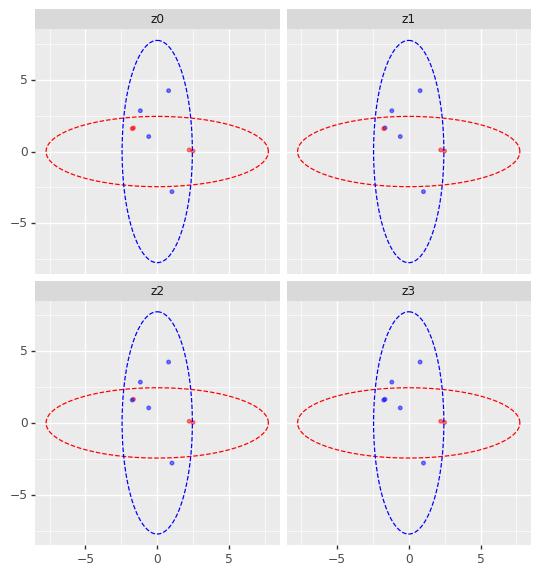

<ggplot: (281520034)>

In [14]:
p = ggplot(tmp)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'factor(color)'), alpha = 0.5, size = 1)
p = p + facet_wrap('labelling') + coord_fixed(ratio=1)
p = p + geom_ellipse(mean = Mu[0], cov = Sigma[0], color='red',  linetype='--')
p = p + geom_ellipse(mean = Mu[1], cov = Sigma[1], color='blue', linetype='--')
p = p + scale_color_manual(values=['red','blue'], breaks=[0,1], guide = False)
p = p + scale_x_continuous(name="") + scale_y_continuous(name="") + coord_fixed()
display(p)

### Implementation for decomposable label distribution

As it turns out later, we need to evaluate $F(q,\boldsymbol{\Theta})$ only for distributions for which we assign the probability of a labelling under independence assumption, i.e.,

\begin{align*}
q(\boldsymbol{z})=\prod_{i=1}^n \Pr[z_i] =\prod_{i=1}^n w_{iz_i}
\end{align*}

where $\boldsymbol{\mathrm W}=(w_{ij})$ is the $n\times k$ matrix of weights such that rows sum to one and $k$ is the number of clusters. Then the formula for the lower bound can be expanded:

\begin{align*}
F(\boldsymbol{\mathrm W},\boldsymbol{\Theta})
&=\log p[\boldsymbol{\Theta}] + 
\sum_{\boldsymbol{z}}q(\boldsymbol{z})\cdot\log\biggl(\frac{p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{z}|\boldsymbol{\Theta}]}{q(\boldsymbol{z})}\biggr)\\
&=\log p[\boldsymbol{\Theta}] + 
\sum_{\boldsymbol{z}}
\prod_{\ell=1}^n w_{\ell z_\ell}
\cdot\sum_{i=1}^n\log\biggl(\frac{p[\boldsymbol{x}_i,z_i|\boldsymbol{\Theta}]}{w_{i z_i}}\biggr)\\
&=\log p[\boldsymbol{\Theta}] - 
\sum_{\boldsymbol{z}}
\prod_{\ell=1}^n w_{\ell z_\ell}
\cdot\sum_{i=1}^n\log w_{i z_i}+
\sum_{\boldsymbol{z}}
\prod_{\ell=1}^n w_{\ell z_\ell}
\cdot\sum_{i=1}^n\log(p[\boldsymbol{x}_i,z_i|\boldsymbol{\Theta}])\enspace.\\
\end{align*}

As the second term is the entropy of the distribution where each vector element is independent, we get

\begin{align*}
F(\boldsymbol{\mathrm W},\boldsymbol{\Theta})
&=\log p[\boldsymbol{\Theta}] -
\sum_{i=1}^n \sum_{j=1}^k w_{ij}\log w_{ij}+
\sum_{i=1}^n 
\sum_{\boldsymbol{z}}
\prod_{\ell=1}^n w_{\ell z_\ell}\cdot\log(p[\boldsymbol{x}_i,z_i|\boldsymbol{\Theta}])\enspace.\\
\end{align*}

Although it is not easy to see, the summand of the last term 

\begin{align*}
s_i=
\sum_{\boldsymbol{z}}
\prod_{\ell=1}^n w_{\ell z_\ell}\cdot\log(p[\boldsymbol{x}_i,z_i|\boldsymbol{\Theta}])=
\sum_{\boldsymbol{z}} w_{1z_1}\cdots w_{i-1 z_{i-1}} w_{iz_i} \log(p[\boldsymbol{x}_i,z_i|\boldsymbol{\Theta}])w_{i+1z_{i+1}}\cdots w_{nz_n}
\end{align*}

can be viewed as a standard sum over products

\begin{align*}
\sum_{\boldsymbol{z}}\prod_{\ell=1}^n 
a_{\ell z_\ell}=\prod_{\ell=1}^n\sum_{j=1}^k a_{\ell j}
\end{align*}

where $k$ is the number of potential labels and 

\begin{align*}
a_{\ell z_\ell}=
\begin{cases}
w_{\ell z_\ell} &\text{if } i\neq \ell\enspace,\\
w_{i z_i}\cdot \log\left(p[\boldsymbol{x}_i,z_i|\boldsymbol{\Theta}]\right) &\text{if } i= \ell\enspace.
\end{cases}
\end{align*} 

As a result, we can simplify the summand

\begin{align*}
s_i=\prod_{\ell=1\atop \ell\neq i}^n\left(\sum_{j=1}^k w_{\ell j}\right)\cdot
\left(\sum_{j=1}^k w_{ij}\cdot \log\left(p[\boldsymbol{x}_i,z_i=j|\boldsymbol{\Theta}]\right)\right)\enspace.
\end{align*}

As all rows of the weight matrix sum to one, the first term wanishes and we are left with a simpler expression

\begin{align*}
s_i=\sum_{j=1}^k w_{ij}\cdot \log\left(p[\boldsymbol{x}_i,z_i=j|\boldsymbol{\Theta}]\right)
= \sum_{j=1}^k w_{ij}\cdot \log\left(p[z_i=j|\boldsymbol{\Theta}]\right)
+\sum_{j=1}^k w_{ij}\cdot \log\left(p[\boldsymbol{x}_i|z_i=j,\boldsymbol{\Theta}_j]\right) 
\enspace.
\end{align*}

Therefore, we can simplify the lower bound even further:

\begin{align*}
F(\boldsymbol{\mathrm W},\boldsymbol{\Theta})
&=\log p[\boldsymbol{\Theta}] -
\sum_{i=1}^n \sum_{j=1}^k w_{ij}\log w_{ij}
+
\sum_{i=1}^n \sum_{j=1}^k w_{ij}\cdot \log\lambda_j
+
\sum_{i=1}^n 
\sum_{j=1}^k w_{ij}\cdot \log\left(p[\boldsymbol{x}_i|\boldsymbol{\Theta}_j]\right)\enspace.
\end{align*}

Now we can define $F(\boldsymbol{\mathrm W},\boldsymbol{\Theta})$ as a sum of four subfunctions

\begin{align*}
F_0(\boldsymbol{\Theta})&=\log p[\boldsymbol{\Theta}]\\
F_1(\boldsymbol{\mathrm W})&= -\sum_{i=1}^n \sum_{j=1}^k w_{ij}\log w_{ij}\\
F_2(\boldsymbol{\mathrm W}, \boldsymbol{\lambda})&=\sum_{j=1}^k \log\lambda_j\cdot \sum_{i=1}^n w_{ij} \\
F_3(\boldsymbol{\mathrm W},\boldsymbol{\Theta})&= \sum_{i=1}^n 
\sum_{j=1}^k w_{ij}\cdot \log\left(p[\boldsymbol{x}_i|\boldsymbol{\Theta}_j]\right)\\
\end{align*}

In [15]:
def Fw(df:DataFrame, W:np.array, Lambda:List[float], Mu:List[List[float]], Sigma:List[np.array]) -> float:
    """Lower bound function specified in terms of a weight matrix"""
        
    
    # Entropy of labelling
    F1 = -np.nansum(W * np.log(W))
    
    # Cross entropy between weights and mixture proportions
    F2 = np.nansum(np.log(Lambda) * np.sum(W, axis=0))
    
    # Loglikelihood for each label
    LP = np.full([n, 2], np.nan)
    LP[:, 0] = multivariate_normal.logpdf(df[['x', 'y']], mean=Mu[0], cov=Sigma[0])
    LP[:, 1] = multivariate_normal.logpdf(df[['x', 'y']], mean=Mu[1], cov=Sigma[1])

    # Fractional log-likelihood
    F3 = np.nansum(W * LP)
    
    return F1 + F2 + F3 

Compute normalised weights as in the EM-algorithm and test the algorithm on it.

In [16]:
P = np.full([n, 2], np.nan)
P[:, 0] = Lambda[0] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu[0], cov=Sigma[0])
P[:, 1] = Lambda[1] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu[1], cov=Sigma[1])
W = P/np.sum(P, axis=1)[:, np.newaxis]

p = (combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})
     .assign(pr = lambda df: df.apply(lambda z: P[range(n), z].prod(), axis=1)) 
     .set_index(['z{:d}'.format(i) for i in range(n)]))

q = p/p.sum()

print('Lower bound F(p, Theta): {:g}'.format(Fq(df, q, Lambda, Mu, Sigma)))
print('Lower bound F(W, Theta): {:g}'.format(Fw(df, W, Lambda, Mu, Sigma)))

Lower bound F(p, Theta): -34.311
Lower bound F(W, Theta): -34.311


Let's take random weights and see how well it behaves.

In [17]:
W1 = rnd.uniform(size = 2*n).reshape([n,2])
W1 = W1/np.sum(W1, axis=1)[:, np.newaxis]

q1 = (combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})
     .assign(pr = lambda df: df.apply(lambda z: W1[range(n), z].prod(), axis=1)) 
     .set_index(['z{:d}'.format(i) for i in range(n)]))

print('Lower bound F(q*, Theta): {:g}'.format(Fq(df, q, Lambda, Mu, Sigma)))
print('Lower bound F(W*, Theta): {:g}'.format(Fw(df, W, Lambda, Mu, Sigma)))
print('Lower bound F(q,  Theta): {:g}'.format(Fq(df, q1, Lambda, Mu, Sigma)))
print('Lower bound F(W,  Theta): {:g}'.format(Fw(df, W1, Lambda, Mu, Sigma)))
print(Fq(df, q, Lambda, Mu, Sigma) - Fw(df, W, Lambda, Mu, Sigma))
print(Fq(df, q1, Lambda, Mu, Sigma) - Fw(df, W1, Lambda, Mu, Sigma))

Lower bound F(q*, Theta): -34.311
Lower bound F(W*, Theta): -34.311
Lower bound F(q,  Theta): -41.2416
Lower bound F(W,  Theta): -41.2416
-2.1316282072803006e-14
2.1316282072803006e-14


## IV. Expectation step

Note that the lower bound can be further decomposed as

\begin{align*}
F(q,\boldsymbol{\Theta})&=
\sum_{\boldsymbol{z}}q(\boldsymbol{z})\cdot\log\biggl(\frac{p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{z}|\boldsymbol{\Theta}]}{q(\boldsymbol{z})}\biggr)\\
&=
\log\bigl(p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n|\boldsymbol{\Theta}]\bigr)+
\sum_{\boldsymbol{z}}q(\boldsymbol{z})\cdot\log\biggl(\frac{p[\boldsymbol{z}| \boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\boldsymbol{\Theta}]}{q(\boldsymbol{z})}\biggr)
\end{align*}
where the second term can be viewed as an opposite to [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) 

\begin{align*}
D(q|| p)=\sum_\boldsymbol{z} q[\boldsymbol{z}]\cdot \log\biggl(\frac{q[\boldsymbol{z}]}{p[\boldsymbol{z}]}\biggr)
= \sum_\boldsymbol{z} q[\boldsymbol{z}]\cdot \log(q[\boldsymbol{z}]) - \sum_\boldsymbol{z} q[\boldsymbol{z}] \cdot\log(p[\boldsymbol{z}])
\end{align*}

for the label distribution $p[\boldsymbol{z}]=p[\boldsymbol{z}|\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n,\boldsymbol{\Theta}]$.
Hence, the labelling distribution $q[\boldsymbol{z}]$ maximises $F(q,\boldsymbol{\Theta})$ if and only if it minimises Kullback-Leibler divergence. The latter occurs only if $q[\boldsymbol{z}]=p[\boldsymbol{z}]$. 

As the distribution $p[\boldsymbol{z}]$ is a product of independent components, we can define $q[\boldsymbol{z}]$ in terms of a weight matrix $\boldsymbol{\mathrm W}$ where

\begin{align*}
w_{ij}
&=p[z_i=j|\boldsymbol{x}_i,\boldsymbol{\Theta}]\
\propto \Pr[z_i=j|\boldsymbol{\Theta}]\cdot p[\boldsymbol{x}_i|z_i=j,\boldsymbol{\Theta}]
\propto\lambda_j\cdot p[\boldsymbol{x}_i|\boldsymbol{\Theta}_j]\enspace.
\end{align*}

This assignment removes the second term from $F(q,\boldsymbol{\Theta})$ and thus the lower bound coincides with the marginal likelihood:

\begin{align*}
F(q,\boldsymbol{\Theta})&=F(\boldsymbol{\mathrm W}, \boldsymbol{\Theta})=
\log\bigl(p[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n|\boldsymbol{\Theta}]\bigr)\enspace.
\end{align*}

## V. Maximisation step

For a fixed weight matrix $\boldsymbol{\mathrm W}$ the term $F_1(\boldsymbol{W})$ is constant and we need to maximize the sum

\begin{align*}
F_0(\boldsymbol{\Theta})+F_2(\boldsymbol{\mathrm W},\boldsymbol{\lambda})+F_3(\boldsymbol{\mathrm W},\boldsymbol{\Theta})\enspace.
\end{align*}

Since $F_3(\boldsymbol{\mathrm W},\boldsymbol{\Theta})$ does not depend on mixture proportions $\boldsymbol{\lambda}$, we have two separate maximisation goals:

\begin{align*}
F_2(\boldsymbol{\mathrm W},\boldsymbol{\lambda})&\xrightarrow[\boldsymbol{\lambda}]{}\max\enspace,\\
F_0(\boldsymbol{\Theta}) + F_3(\boldsymbol{\mathrm W},\boldsymbol{\Theta})&\xrightarrow[\boldsymbol{\Theta}]{}\max\enspace.\\
\end{align*}

As $F_2(\boldsymbol{\mathrm W},\boldsymbol{\lambda})$ can be viewed as opposite of a cross-entropy expression, we can derive 

\begin{align*}
\lambda_j=\frac{\sum_{i=1}^n w_{ij}}{\sum_{i=1}^n\sum_{j=1}^k w_{ij}}\enspace.
\end{align*}

All the remaining parameters can be found by maximising the expression 

\begin{align*}
F_0(\boldsymbol{\Theta}) + F_3(\boldsymbol{\mathrm W},\boldsymbol{\Theta})=
\log p[\boldsymbol{\Theta}] +
\sum_{i=1}^n 
\sum_{j=1}^k w_{ij}\cdot \log\left(p[\boldsymbol{x}_i,z_i=j|\boldsymbol{\Theta}]\right)
\end{align*}

which is the optimisation task we got for the soft clustering algorithm derived in the lecture, modulo a minor detail that we did not assign informative prior to model parameters. 

## VI. Commonly used alternative notation

Notation $F(q, \boldsymbol{\Theta})$ is one of the ways to denote the lower bound that is maximised in soft-clustering. Another alternative is to use slightly different formalisation of the same concept

\begin{align*}
Q(\boldsymbol{\Theta}, \boldsymbol{\Theta}_0):= \mathbf{\mathrm E}(\log(p[\boldsymbol{x}_1,\ldots,\boldsymbol{x_n},\boldsymbol{z}|\boldsymbol{\Theta}]\,|\,\boldsymbol{x}_1,\ldots,\boldsymbol{x_n}, \boldsymbol{\Theta}_0)
\end{align*}
where the expexctation is computed over $\boldsymbol{z}$ and the probability of each combination is computed as $p[\boldsymbol{z}|\boldsymbol{x}_1,\ldots,\boldsymbol{x_n}, \boldsymbol{\Theta}_0]$. As a result, the Q-function can be expressed

\begin{align*}
Q(\boldsymbol{\Theta}, \boldsymbol{\Theta}_0)=\sum_{\boldsymbol{z}} p[\boldsymbol{z}|\boldsymbol{x}_1,\ldots,\boldsymbol{x_n}, \boldsymbol{\Theta}_0]\cdot\log(p[\boldsymbol{x}_1,\ldots,\boldsymbol{x_n},\boldsymbol{z}|\boldsymbol{\Theta}]\enspace.
\end{align*}

From this expression it is straightforward to see that 

\begin{align*}
Q(\boldsymbol{\Theta}, \boldsymbol{\Theta}_0)= F(q, \boldsymbol{\Theta})
\end{align*}

after the E-step is performed for parameters $\boldsymbol{\Theta}_0$.
This link should clarify the differences with our treatment and the one of the best formal treatment on this topic:
* [Jeff A. Bilmes. A Gentle Tutorial of the EM Algorithm and its Application to Parameter Estimation for Gaussian Mixture and Hidden Markov Models](http://www-prima.imag.fr/Prima/jlc/Courses/2006/ENSI2.SIRR/EM-tutorial.pdf).

## VII. Reference implementations for Gaussian components

To simplify home exercises, we provide reference implementations for hard and soft clustering algorithms. 

### Initial parameter values for all our experiments

There are several ways to store parameters in the two-step maximisation algorithm. We choose the most pandas-like reresentation that uses indices for selecting parameters for individual clusters.

In [ ]:
df = pd.read_csv('data/gmm-challenges/challenge-3.csv')

Mu = (DataFrame(np.array([
                [-2.5255070, -1.1330980],
                [ 2.5015790,  2.6051860],
                [-0.1547520, -0.4935437]]),columns=['x', 'y'])
      .assign(cluster = range(3))
      .set_index('cluster'))

Sigma = DataFrame(np.identity(2), columns = ['x', 'y'], index = ['x', 'y'])
Sigma = pd.concat([Sigma.assign(cluster = j) for j in range(3)]).set_index('cluster')

mdisplay([Mu.reset_index(), Sigma.reset_index()], [r'$\mu$', r'$\Sigma$'])

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y'), alpha = 0.5)
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
for i, color in enumerate(['red', 'green', 'blue']):
    p = p + geom_point(x = Mu.loc[i,'x'], y = Mu.loc[i, 'y'], color = color, shape = 'x', size = 2)
    p = p + geom_ellipse(mean=Mu.loc[i], cov=Sigma.loc[i], color=color)
display(p)

### Hard clustering algorithm for Gaussian components

The two-step algorithm specified below logs all parameter values during its work. For that we use data frames with multi-indices. This can lead to [subtle errors when we want to assign data frames](https://stackoverflow.com/questions/28431519/pandas-multiindex-assignment-from-another-dataframe) due to index mismatches. Thus, we cast the data frames to `numpy` arrays.  

In [ ]:
def HardGMMClustering2D(data: DataFrame, Mu:np.array, Sigma:np.array, maxit:int = 100):
    """Computes hard clustering and stores all intermediate values"""
    
    if len(Mu) != len(Sigma.index.unique()):
       Exception("Incorrectly specified initial paramaters")
       
    # Dimensions    
    k = len(Mu)
    n = data.shape[0]
    maxit = maxit + 1
    
    # Make sure that we do not alter inputs
    Mu = Mu.copy()
    Sigma = Sigma.copy()
    
    # Lets also store the log likelyhood of the model
    LLM = np.full([2 * maxit], np.nan)

    # Lets store all labellings and parameter values throughout the search
    Z = DataFrame(np.full([maxit, n], np.nan))  
    
    MU = (DataFrame(np.full([k * maxit, 2], np.nan), columns = ['x', 'y'])
          .assign(cluster = list(range(k)) * maxit)
          .assign(t = sum([[i] *  k for i in range(maxit)], []))
          .set_index(['t', 'cluster']))
    
    SIGMA = (DataFrame(np.full([maxit * 2 *  k, 2], np.nan), columns = ['x', 'y'])
             .assign(cluster = sum([[j, j] for j in range(k)],[]) * maxit)
             .assign(t = sum([[i] *  2 * k for i in range(maxit)], []))
             .set_index(['t', 'cluster']))   
    
    # Store parameters. Downcast to array to force assignment.
    MU.loc[0] = Mu.values
    SIGMA.loc[0] = Sigma.values
    
    for t in range(1, maxit):
        
        # Step M1: Find cluster probabilities and assign the label to most probable cluster
        lp = np.full([n, k], np.nan)
        
        for j in range(k):
            lp[:, j] = multivariate_normal.logpdf(data, mean = Mu.loc[j], cov = Sigma.loc[j]) 
            
        # Note that we should choose the most probable cluster!
        Z.loc[t] = lp.argmax(axis = 1)

        # Now we can compute the estimate of log p[data|z, Mu, Sigma]
        LLM[2 * t - 2] = np.amax(lp, axis=1).sum()
        

        # Obvious stop condition: Stop if the previous labelling was the same as the current labelling
        if all(Z.loc[t - 1] == Z.loc[t]):
            maxit = t  
            break    
        

        # Step M2: Recalibrate parameters for different clusters
        ll = np.full([k], np.nan)
        for j in range(k):
            
            # Select cluster points 
            X = data.loc[Z.loc[t] == j].values

            # Cluster center estimation
            Mu.loc[j] = np.mean(X, axis=0)
            
            # Cluster shape estimation
            # Center the data and compute the covariance
            X[:, 0] = X[:, 0] - Mu.loc[j, 'x']  
            X[:, 1] = X[:, 1] - Mu.loc[j, 'y'] 
            Sigma.loc[j] = 1/sum(Z.loc[t]==j) * np.dot(X.T, X)  
            
            # Update probability estimate for the cluster based on centered data 
            ll[j] = np.sum(multivariate_normal.logpdf(X, cov = Sigma.loc[j]))
            
        # Store loglikelihood    
        LLM[2 * t - 1] = sum(ll)

        # Store parameters. Downcast to array to force assignment.
        MU.loc[t] = Mu.values
        SIGMA.loc[t] = Sigma.values
     
    LLM = (DataFrame(LLM[:2 * maxit - 2], columns = ['loglikelihood'])
           .assign(t = sum([[i, i] for i in range(1, maxit)], []))
           .assign(step = sum([['M1', 'M2'] for i in range(1, maxit)], [])) 
           .assign(i = range(2 * maxit - 2))[['i', 't', 'step','loglikelihood']])
    return (Z[:maxit], MU.loc[:maxit-1], SIGMA.loc[:maxit-1], LLM)
        

### Soft clustering algorithm with fractional weights for Gaussian components

In [ ]:
def SoftGMMClustering2D(data: DataFrame, Lambda: np.array,  Mu: np.array, Sigma:np.array, maxit:int = 100):
    """Computes soft clustering and stores all intermediate values"""
    
    if len(Mu) != len(Sigma.index.unique()):
       Exception("Incorrectly specified initial paramaters")
       

    # Dimensions    
    k = len(Mu)
    n = data.shape[0]
    maxit = maxit + 1
    
    # Make sure that we do not alter inputs
    Mu = Mu.copy()
    Sigma = Sigma.copy()
    Lambda = Lambda.iloc[:, 0]
    
    # Lets store all labellings and parameter values throughout the search
    MU = (DataFrame(np.full([k * maxit, 2], np.nan), columns = ['x', 'y'])
          .assign(cluster = list(range(k)) * maxit)
          .assign(t = sum([[i] *  k for i in range(maxit)], []))
          .set_index(['t', 'cluster']))
    
    SIGMA = (DataFrame(np.full([maxit * 2 *  k, 2], np.nan), columns = ['x', 'y'])
             .assign(cluster = sum([[j, j] for j in range(k)],[]) * maxit)
             .assign(t = sum([[i] *  2 * k for i in range(maxit)], []))
             .set_index(['t', 'cluster']))   
    
    LAMBDA = DataFrame(np.full([maxit, k], np.nan)).rename_axis('t')  

    W = (DataFrame(np.full([maxit * n, k], np.nan))
         .assign(t = sum([[i] *  n for i in range(maxit)], []))
         .assign(i = list(range(n)) * maxit)     
         .set_index(['t', 'i']))
    
    # Store parameters. Downcast to array to force assignment.
    MU.loc[0] = Mu.values
    SIGMA.loc[0] = Sigma.values
    LAMBDA.loc[0] =  Lambda
    

    for t in range(1, maxit):
        

        # Step E1: Find cluster weights
        lp = np.full([n, k], np.nan)
        
        # Find cluster probabilities and multiply them with mixture proportions
        for j in range(k):
            lp[:, j] = multivariate_normal.logpdf(data, mean = Mu.loc[j], cov = Sigma.loc[j])
            lp[:, j] += Lambda[j]
            

        # Rescale label posterior by multiping row with constant for numerical stability
        lp = lp - np.amax(lp, axis=1)[:, np.newaxis]
        
        # Go back from logarithmic scale to normal scale
        w = np.exp(lp)
        
        # Set weight as normalised label posterior
        w = w/w.sum(axis=1)[:, np.newaxis]
        W.loc[t] = w

        
        # Step M2: Recalibrate parameters for different clusters
        
        # Estimate mixture proportions
        Lambda = w.sum(axis=0)/w.sum()

        X = np.full([n,2], np.nan)
        for j in range(k):

            # Cluster center estimation
            Mu.loc[j] = np.average(data, weights=w[:,j], axis=0)
        
            # Cluster shape estimation
            # Center the data and compute the weighted covariance
            X[:, 0] = data['x'] - Mu.loc[j, 'x']  
            X[:, 1] = data['y'] - Mu.loc[j, 'y']
            
            Sigma.loc[j] = 1/w[:, j].sum() * np.dot(X.T, w[:, j][:, np.newaxis] * X) 
            

        # Store parameters. Downcast to array to force assignment.
        MU.loc[t] = Mu.values
        SIGMA.loc[t] = Sigma.values
        LAMBDA.loc[t] = Lambda

    
    return (W.loc[:maxit], LAMBDA.loc[:maxit], MU.loc[:maxit-1], SIGMA.loc[:maxit-1])
        

### Sanity check for hard clustering

In [ ]:
df = pd.read_csv('data/gmm-challenges/challenge-3.csv', usecols = [1,2])
Z, MU, SIGMA, LLM = HardGMMClustering2D(df, Mu, Sigma)

p = ggplot(LLM) 
p = p + geom_line(aes(x='i', y = 'loglikelihood'))
p = p + geom_point(aes(x='i', y = 'loglikelihood', color ='step'))
display(p)

tmax = SIGMA.index.get_level_values('t').max()

p = ggplot(df.assign(label = Z.loc[tmax].astype('category')))
p = p + geom_point(aes(x = 'x', y = 'y', color = 'label'), alpha=0.5, size=0.5) + coord_fixed()
for k, color in enumerate(['red', 'green', 'blue']):
    p = p + geom_ellipse(mean = MU.loc[(tmax,k)], cov = SIGMA.loc[(tmax, k)], color = color)
p = p + scale_color_manual(values=['red','green','blue'], breaks=[0,1,2], guide = False)    
display(p)

Mu = MU.loc[tmax]
Sigma = SIGMA.loc[tmax]
Lambda = (DataFrame(Z.loc[tmax].value_counts(normalize=True).rename('probability'))
          .assign(cluster = lambda df: df.index.astype(int))
          .set_index(['cluster']))

mdisplay([Mu.reset_index(), Sigma.reset_index(), Lambda.reset_index()], [r'$\mu$', r'$\Sigma$', r'$\lambda$'])

### Sanity check for soft clustering

In [ ]:
W, LAMBDA, MU, SIGMA = SoftGMMClustering2D(df, Lambda, Mu, Sigma, 100) 
p = ggplot(df
           .assign(red = W.loc[pd.IndexSlice[tmax,:], 0].values)
           .assign(green = W.loc[pd.IndexSlice[tmax,:], 1].values)
           .assign(blue = W.loc[pd.IndexSlice[tmax,:], 2].values))

           
p = p + geom_point(aes(x = 'x', y = 'y', alpha = 'red'), size=0.5, color = 'red')
p = p + geom_point(aes(x = 'x', y = 'y', alpha = 'green'), size=0.5, color = 'green')
p = p + geom_point(aes(x = 'x', y = 'y', alpha = 'blue'), size=0.5, color = 'blue')
p = p + scale_alpha_continuous(range=[0.05, 0.7], guide=False)
p = p + coord_fixed()

tmin = 0
tmax = SIGMA.index.get_level_values('t').max()
for k, color in enumerate(['red', 'green', 'blue']):
    p = p + geom_ellipse(mean = MU.loc[(tmin,k)], cov = SIGMA.loc[(tmin, k)], color = color, linetype='-')

for k, color in enumerate(['red', 'green', 'blue']):
    p = p + geom_ellipse(mean = MU.loc[(tmax,k)], cov = SIGMA.loc[(tmax, k)], color = color, linetype = '--')
display(p)

# Homework

## 3.1 Soft clustering with convergence tracking (<font color='red'>1p</font>)

The reference implementation of the soft clustering algorithm does not track the optimisation goal. Alter the algorithm so that it also stores the lower bound values $F(q, \boldsymbol{\Theta})$, $F(\boldsymbol{\mathrm W}, \boldsymbol{\Theta})$, and the logarithm of the marginalised posterior $\log P(\boldsymbol{\Theta})$. Run it on the toy sample data and plot the evolution of these functions on the graph similarly to the graph that illustrates the convergence of the hard clustering algorithm.

In [ ]:
Mu = [None] * 2
Mu[0] = [0, 0]
Mu[1] = [0, 0]

Sigma = [None] * 2
Sigma[0] = np.array([[10, 0], [0,  1]])
Sigma[1] = np.array([[ 1, 0], [0, 10]])  

k = 4
n = 2 * k

df = [None] * 2
df[0] = DataFrame(multivariate_normal.rvs(size=k, mean=Mu[0], cov=Sigma[0]), 
                  columns=['x', 'y']).assign(z = 0)
df[1] = DataFrame(multivariate_normal.rvs(size=k, mean=Mu[1], cov=Sigma[1]), 
                  columns=['x', 'y']).assign(z = 1)
df = pd.concat(df).assign(z = lambda df: df['z'].astype('category'))

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'z'), alpha = 0.5, size = 1)
p = p + geom_ellipse(mean = Mu[0], cov = Sigma[0], color='red',  linetype='--')
p = p + geom_ellipse(mean = Mu[1], cov = Sigma[1], color='blue', linetype='--')
p = p + scale_color_manual(values=['red','blue'], breaks=[0,1], guide = False)
p = p + scale_x_continuous(name="") + scale_y_continuous(name="") + coord_fixed()
display(p)

mdisplay([df],['Data'])

In [ ]:
def Fq(df:DataFrame, q:DataFrame, Lambda:List[float], Mu:List[List[float]], Sigma:List[np.array]) -> float:
    """Lower bound function specified in terms of labelling probabilities"""
        
    # Likelihood for each labelling
    P = np.full([n, 2], np.nan)
    P[:, 0] = Lambda[0] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu.loc[0], cov=Sigma.loc[0])
    P[:, 1] = Lambda[1] * multivariate_normal.pdf(df[['x', 'y']], mean=Mu.loc[1], cov=Sigma.loc[1])

    Z = (combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})
         .assign(p = lambda df: df.apply(lambda z: P[range(n), z].prod(), axis=1))
         .assign(q = lambda df: df.apply(lambda z: q.loc[tuple(z.iloc[:n])], axis=1))
         .assign(log_term = lambda df: np.log(df['p']/df['q']))) 
    #display(Z)
    return sum(Z['q'] * Z['log_term'])

def Fw(df:DataFrame, W:np.array, Lambda:List[float], Mu:List[List[float]], Sigma:List[np.array]) -> float:
    """Lower bound function specified in terms of a weight matrix"""
        
    
    # Entropy of labelling
    F1 = np.nansum(W * np.log(W))
    
    # Cross entropy between weights and mixture proportions
    F2 = np.nansum(np.log(Lambda) * np.sum(W, axis=0))
    
    # Loglikelihood for each label
    LP = np.full([n, 2], np.nan)
    LP[:, 0] = multivariate_normal.logpdf(df[['x', 'y']], mean=Mu.loc[0], cov=Sigma.loc[0])
    LP[:, 1] = multivariate_normal.logpdf(df[['x', 'y']], mean=Mu.loc[1], cov=Sigma.loc[1])

    # Fractional log-likelihood
    F3 = np.nansum(W * LP)
    
    return -F1 + F2 + F3 

def SoftGMMClustering2DNew(data: DataFrame, Lambda: np.array,  Mu: np.array, Sigma:np.array, maxit:int = 100):
    """Computes soft clustering and stores all intermediate values"""
    
    if len(Mu) != len(Sigma.index.unique()):
       Exception("Incorrectly specified initial paramaters")
       

    # Dimensions    
    k = len(Mu)
    n = data.shape[0]
    maxit = maxit + 1
    
    # Make sure that we do not alter inputs
    Mu = Mu.copy()
    Sigma = Sigma.copy()
    Lambda = Lambda.iloc[:, 0]
    
    # Lets store all labellings and parameter values throughout the search
    MU = (DataFrame(np.full([k * maxit, 2], np.nan), columns = ['x', 'y'])
          .assign(cluster = list(range(k)) * maxit)
          .assign(t = sum([[i] *  k for i in range(maxit)], []))
          .set_index(['t', 'cluster']))
    
    SIGMA = (DataFrame(np.full([maxit * 2 *  k, 2], np.nan), columns = ['x', 'y'])
             .assign(cluster = sum([[j, j] for j in range(k)],[]) * maxit)
             .assign(t = sum([[i] *  2 * k for i in range(maxit)], []))
             .set_index(['t', 'cluster']))   
    
    LAMBDA = DataFrame(np.full([maxit, k], np.nan)).rename_axis('t')  

    W = (DataFrame(np.full([maxit * n, k], np.nan))
         .assign(t = sum([[i] *  n for i in range(maxit)], []))
         .assign(i = list(range(n)) * maxit)     
         .set_index(['t', 'i']))
    
    FQ = np.full([maxit * 2], np.nan)
    FW = np.full([maxit * 2], np.nan)
    LP = np.full([maxit * 2], np.nan)
    
    # Store parameters. Downcast to array to force assignment.
    MU.loc[0] = Mu.values
    SIGMA.loc[0] = Sigma.values
    LAMBDA.loc[0] =  Lambda
    
    # Dataframe with all possible labels
    Z = combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})

    for t in range(1, maxit):

        # Step E1: Find cluster weights
        lp = np.full([n, k], np.nan)
        
        # Find cluster probabilities and multiply them with mixture proportions
        for j in range(k):
            lp[:, j] = multivariate_normal.logpdf(data, mean = Mu.loc[j], cov = Sigma.loc[j])
            lp[:, j] += np.log(Lambda[j])
            
        # Rescale label posterior by multiping row with constant for numerical stability
        #lp = lp - np.amax(lp, axis=1)[:, np.newaxis]
        
        # Go back from logarithmic scale to normal scale
        w = np.exp(lp)
        
        # Compute probabilities for all labellings
        p = (Z
             .assign(pr = lambda df: df.apply(lambda z: w[range(n), z].prod(), axis=1)) 
             .set_index(['z{:d}'.format(i) for i in range(n)]))
        q = p/p.sum()
        
        # Set weight as normalised label posterior
        w = w/w.sum(axis=1)[:, np.newaxis]
        W.loc[t] = w
        
        FQ[2 * t - 2] = Fq(data, q, Lambda, Mu, Sigma)
        FW[2 * t - 2] = Fw(data, w, Lambda, Mu, Sigma)
        if t > 1:
            LP[2 * t - 3] = np.log(p.sum()[0])
        LP[2 * t - 2] = np.log(p.sum()[0])
        
        # Step M2: Recalibrate parameters for different clusters
        
        # Estimate mixture proportions
        Lambda = w.sum(axis=0)/w.sum()

        X = np.full([n,2], np.nan)
        for j in range(k):

            # Cluster center estimation
            Mu.loc[j] = np.average(data, weights=w[:,j], axis=0)
        
            # Cluster shape estimation
            # Center the data and compute the weighted covariance
            X[:, 0] = data['x'] - Mu.loc[j, 'x']  
            X[:, 1] = data['y'] - Mu.loc[j, 'y']
            
            Sigma.loc[j] = 1/w[:, j].sum() * np.dot(X.T, w[:, j][:, np.newaxis] * X) 
            

        # Store parameters. Downcast to array to force assignment.
        MU.loc[t] = Mu.values
        SIGMA.loc[t] = Sigma.values
        LAMBDA.loc[t] = Lambda

        FQ[2 * t - 1] = Fq(data, q, Lambda, Mu, Sigma)
        FW[2 * t - 1] = Fw(data, w, Lambda, Mu, Sigma)
    
    
    FQ = (DataFrame(FQ[:2 * maxit - 2], columns = ['loglikelihood'])
      .assign(t = sum([[i, i] for i in range(1, maxit)], []))
      .assign(step = sum([['E1', 'M2'] for i in range(1, maxit)], [])) 
      .assign(i = range(2 * maxit - 2))[['i', 't', 'step','loglikelihood']])
    FW = (DataFrame(FW[:2 * maxit - 2], columns = ['loglikelihood'])
      .assign(t = sum([[i, i] for i in range(1, maxit)], []))
      .assign(step = sum([['E1', 'M2'] for i in range(1, maxit)], [])) 
      .assign(i = range(2 * maxit - 2))[['i', 't', 'step','loglikelihood']])
    LP = (DataFrame(LP[:2 * maxit - 2], columns = ['loglikelihood'])
      .assign(t = sum([[i, i] for i in range(1, maxit)], []))
      .assign(step = sum([['E1', 'M2'] for i in range(1, maxit)], [])) 
      .assign(i = range(2 * maxit - 2))[['i', 't', 'step','loglikelihood']])
    
    return (W.loc[:maxit], LAMBDA.loc[:maxit], MU.loc[:maxit-1], SIGMA.loc[:maxit-1], 
            FQ[:maxit+1], FW[:maxit+1], LP[:maxit+1])

In [ ]:
Lambda = DataFrame(np.array([0.5, 0.5]))
Mu = (DataFrame(np.array([
                [-2.5255070, -1.1330980],
                [ 2.5015790,  2.6051860]]),columns=['x', 'y'])
      .assign(cluster = range(2))
      .set_index('cluster'))

Sigma = DataFrame(np.identity(2), columns = ['x', 'y'], index = ['x', 'y'])
Sigma = pd.concat([Sigma.assign(cluster = j) for j in range(2)]).set_index('cluster')

In [ ]:
df

In [ ]:
W, LAMBDA, MU, SIGMA, FQ, FW, LP = SoftGMMClustering2DNew(df[['x', 'y']], Lambda,  Mu, Sigma, maxit=4)

In [ ]:
ScoreType = CategoricalDtype(['LogP', 'FQ', 'FW'], ordered = True)
p = ggplot((pd.concat([LP.assign(score='LogP'), FQ.assign(score='FQ'), FW.assign(score='FW')]).
           astype({'score': ScoreType})))
p = p + geom_line(aes(x='i', y = 'loglikelihood', linetype='score'))
p = p + geom_point(aes(x='i', y = 'loglikelihood', color ='step'))
display(p)

In [ ]:
n = len(df)
Z=combine_categories({'z{:d}'.format(i):[0,1] for i in range(n)})
head(Z)

In [ ]:
W = np.full([8,2], 0)
n=8
p = (Z
     .assign(pr = lambda df: df.apply(lambda z: W[range(n), z].prod(), axis=1)) 
     .set_index(['z{:d}'.format(i) for i in range(n)]))

head(p)

## 3.2 Direct minimisation of marginal posterior (<font color='red'>2p</font>)

The fact that the lower bound $F(\boldsymbol{\mathrm W}, \boldsymbol{\Theta})$ is equal to the logarithm of the marginal posterior $\log P(\boldsymbol{\Theta})$ provides a shorcut to posterior marginalisation. Using this fact or the direct formula for $L(\boldsymbol{\Theta})$, perform a grid search over a reduced parameter space described below:

* We assume that clusters are given by coloured Gaussians $\mathcal{N}(\boldsymbol{0},\boldsymbol{\Sigma}_1)$ and $\mathcal{N}(\boldsymbol{0},\boldsymbol{\Sigma}_2)$ where 

    \begin{align*}
    \boldsymbol{\Sigma}_1
    =\begin{pmatrix}
    \sigma_1^2 &0\\
    0& 1
    \end{pmatrix}\enspace,
    \qquad
    \boldsymbol{\Sigma}_2
    =\begin{pmatrix}
    1 &0\\
    0& \sigma_2^2
    \end{pmatrix}\enspace.\\
    \end{align*}
 
* We assume that mixture proportions $\lambda_1=\frac{1}{2}$ and $\lambda_2=\frac{1}{2}$ are also fixed and known.
 
Then the marginal posterior is a two-dimensional function $P(\sigma_1, \sigma_2)$ that can be directly evaluated over a fixed sized grid.

Generate a reasonable amount of data (say $n=100$) with parameter values $\sigma_1=3.2$ and $\sigma_2=3.2$, and graph $\log P(\sigma_1,\sigma_2)$ values in a reasonable range (<font color='red'>**1p**</font>). Run the soft clustering algorithm from several starting points in this range and draw the path to the same graph (<font color='red'>**1p**</font>). Draw the evolution of the marginal posterior values as separate graphs and interpret results (<font color='red'>**1p**</font>).

## 3.3 Robust soft clustering algorithm with convergence tracking (<font color='red'>2p</font>)

The standard Gaussian mixture model is prone to outliers. Add a Poisson component $p({\boldsymbol{x}|\alpha})=\alpha$ for all $\boldsymbol{x}$. Modify the reference implementation so that it would also track the lower bound function $F(\boldsymbol{\mathrm W}, \boldsymbol{\Theta})$ and logarithm of the marginal posterior $\log P(\boldsymbol{\Theta})$. Test it on the third clustering challenge [gmm-challenges/challenge-3.csv](data/gmm-challenges/challenge-3.csv) and plot the evolution of the log-posterior and its lower bound. Plot the final cluster shapes together with cluster weights.   

## 3.4 Soft clustering with different data weighting schemes* (<font color='red'>2p</font>)

In the lecture slides we had three ways for assigning weights. Implement soft clustering algorithm for each weighting scheme and visualise its behaviour on the second and third clustering challenges [gmm-challenges/challenge-2.csv](data/gmm-challenges/challenge-2.csv) and [gmm-challenges/challenge-3.csv](data/gmm-challenges/challenge-3.csv):

* plot the evolution of cluster centers
* plot the evolution of log-posterior
* plot the final cluster shapes together with cluster weights. 

Interpret the results.